# Predicting phases of larger Rydberg-atom systems with Conditional Generative Models

Haoxiang Wang (hwang264@illinois.edu)

Work done as an applied scientist intern at Amazon Braket in 2022

In [1]:
import sys
# to read modules from the parent directory
sys.path.insert(0,'..')

In [2]:
import argparse
import numpy as np
import os
from constants import *
from src.training.rydberg_trainers import RydbergConditionalTransformerTrainer
from src.models.transformer import init_conditional_transformer
from src.models.mlp import MLP
from src.eval.eval_rydberg import est_density_from_z_measurements,est_order_param_1D,est_order_param_2D,est_order_param_1D_from_measurements
from src.eval.eval_rydberg import determine_phase_1D,est_order_param_1D,est_order_param_1D_from_measurements,est_order_param_1D_fourier,est_order_param_1D_fourier_from_measurements
from src.eval.eval_rydberg import get_neighbors,est_staggered_magnetization,single_site_staggered_magnetization,est_avg_corr_cov_2D
from src.utils import measurement2readout_obs
from src.data.loading.dataset_rydberg import RydbergDataset,unif_sample_on_grid
from tqdm.notebook import tqdm,trange
import torch
from torch import nn
import matplotlib.pyplot as plt
import scipy
import pickle
import warnings
import shutil
import imageio
import ipywidgets as widgets
import seaborn as sns
from copy import deepcopy
from src.utils import plot_phase_diagram
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

Define hyper-parameters and configuration variables.

In [3]:
def parse_args(args=[]):
    parser = argparse.ArgumentParser()
    parser.add_argument('--data-dir', type=str, default='logs/rydberg/debug/')
    parser.add_argument('--dim',type=int,default=1)
    parser.add_argument('--nx',type=int,default=19)
    parser.add_argument('--ny',type=int,default=1)
    parser.add_argument('--total_time',type=float,default=6)
    parser.add_argument('--results-dir', type=str, default='results-debug')
    parser.add_argument('--tf-arch', type=str, default='transformer_l4_d128_h4')
    parser.add_argument('--train-id', type=str, default="debug")
    parser.add_argument('--reps', type=int, default=1)
    parser.add_argument('--ns', type=int, default=800, help='number of samples per hamiltonian')
    parser.add_argument('--iterations', type=int, default=500000, help="training iterations")
    parser.add_argument('--eval-every', type=int, default=1000)
    parser.add_argument('--n_cpu', type=int, default=8, help='number of cpu threads to use during batch generation')
    parser.add_argument('--verbose', type=int, default=1, choices=[0, 1])
    parser.add_argument('--epoch-mode', type=int, default=1, choices=[0, 1])
    parser.add_argument('--condition-mode', type=int, default=0, choices=[0, 1])
    parser.add_argument('--seed', type=int, default=None)
    return parser.parse_args(args)


def get_hyperparams(**kwargs):
    hparams = argparse.Namespace(
        lr=1e-3,
        wd=0,
        bs=512,
        dropout=0.0,
        lr_scheduler=WARMUP_COSINE_SCHEDULER,
        warmup_frac=0.,
        final_lr=1e-7,
        smoothing=0.0,
        use_padding=0,
        val_frac=0.25,
        cattn=0
    )

    for k, v in kwargs.items():
        setattr(hparams, k, v)

    return hparams

In [4]:
args = parse_args()
hparams = get_hyperparams()

In [5]:


dim=1 # dimension of the system
ny = 1 # since we are working in 1D, this variable is fixed to 1

total_time = 15 # Total adiabatic evolution time of the Bloqade simulation
# We load simulation data for the lattice defined above with the adiabatic evolution scheduler preset above.
meta_datasets = {}

order_params = ['Z2','Z3',]
hue_order = ['Disordered'] + order_params
n_gen_samples = 1000

all_nqs = np.arange(13,34,2).astype(int)
z2_threshold = 0.7 # threshold for the Z2 order parameter to determine a state is in Z2 phase
z3_threshold = 0.6 # threshold for the Z3 order parameter to determine a state is in Z3 phase

root = '../'
for n_qubits in tqdm(all_nqs):
    nx = n_qubits
    folder = root + f'data/rydberg/1D-Phase_{nx}/{float(np.round(total_time,2))}µs/'
    # extra variables we want the conditional generative variable to condition on, except for "nx", "ny", "interaction_range".
    # detuning = Delta/Omega
    extra_variables = ["detuning",] 
    meta_dataset = RydbergDataset(dim=dim,nx = nx, ny=ny, folder=folder,n_threads=20, 
                                             var_name='interaction_range',variables = extra_variables) 
    meta_dataset.est_order_params()
    meta_dataset.info["phase" ] = determine_phase_1D(meta_dataset.info["Z2"], meta_dataset.info["Z3"],z3_threshold=z3_threshold,z2_threshold=z2_threshold)
    meta_datasets[nx] = meta_dataset

  0%|          | 0/11 [00:00<?, ?it/s]

In [6]:
def process_df(input_df):
    df = input_df.copy()
    new_df = df.loc[(df['detuning'] >= -1)&(df['interaction_range'] <= 2.8)&(df['interaction_range'] > 1.)]
    return new_df

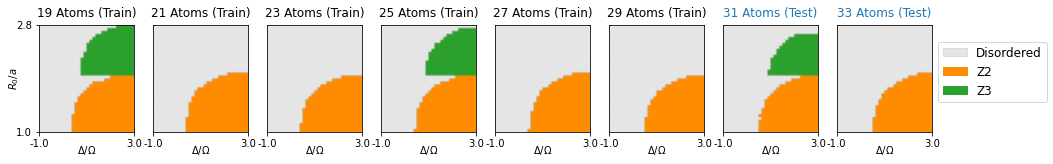

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=8,figsize=(16,2.5))
plot_nqs = [19,21,23,25,27,29,31,33]
for j,nx in enumerate(plot_nqs):
    plot_df = process_df(meta_datasets[nx].info.copy())

    plot_df['phase'] = determine_phase_1D(plot_df['Z2'].values,plot_df['Z3'].values,z3_threshold=z3_threshold,z2_threshold=z2_threshold,)
    plot_df = plot_df.sort_values(['phase'])
    stage = 'Train' if (nx < 31) else 'Test'
    title = f"{nx} Atoms ({stage})"
    title_config  = {'color':'tab:blue','y':1.02} if stage == 'Test' else {}
    legend_config=dict(loc='upper left', fontsize=12, bbox_to_anchor=(1., .9))
    if j == 0: kwargs = dict(y_label=True,y_ticks=True,legend=False)
    else: kwargs = dict(y_label=False,y_ticks=False,legend=False, )
    if j == len(plot_nqs) - 1: kwargs['legend'] = True
    plot_phase_diagram(plot_df,title=title,given_ax=axes[j],legend_config=legend_config,
                       title_config=title_config,hue_order=hue_order,
                       **kwargs)
# fig.tight_layout()
# fig.savefig(root+'figs/paper/1D-rydberg-size_true.png',dpi=200)
# fig.savefig(root+'figs/paper/1D-rydberg-size_true.pdf',)

In [8]:
def prepare_dataset(meta_datasets,train_domains:list,n_measurements:int = 1000):
    train_set = {}
    for t in train_domains:
        meta_dataset = meta_datasets[t]
        df = meta_dataset.info
        df = process_df(df)
        train_keys = meta_dataset.keys[df.index]
        train_set.update(meta_dataset.prepare_train_set(train_keys,n_measurements=n_measurements))
    return train_set

**Train set**: Lattices of atoms = 13,15,...,29

In [9]:
train_nqs = all_nqs[(all_nqs >= 13) * (all_nqs <= 29)]
train_set = prepare_dataset(meta_datasets,train_domains=train_nqs,n_measurements=-1)

Define some hyper-parameters for the model & training.

In [10]:
num_outcomes = 2 # for rydberg systems

n_vars = len(list(train_set.keys())[0])
gpu_idx = 3
device = torch.device(f"cuda:{gpu_idx}")

rng = np.random.default_rng(seed=args.seed)
# setup transformer
d_model = TF_ARCHS[args.tf_arch]['d_model']
n_head = TF_ARCHS[args.tf_arch]['n_head']
n_layers = TF_ARCHS[args.tf_arch]['n_layers']
assert d_model % n_head == 0, 'd_model must be integer multiple of n_head!'

We construct a MLP (fully-connected net) as the encoder and a transformer as the generative model, and then train the model

In [11]:
encoder = MLP(input_size=n_vars, output_size=d_model, 
              n_layers=1, hidden_size=128, activation='ELU', 
              input_layer_norm=False,
              output_batch_size=None, device=device,
             output_factor=1.)

transformer = init_conditional_transformer(
        n_outcomes=num_outcomes,
        encoder=encoder,
        n_layers=n_layers,
        d_model=d_model,
        d_ff=4 * d_model,
        n_heads=n_head,
        dropout=hparams.dropout,
        version=hparams.use_padding,
        use_prompt=False,
)

Construct a trainer for the conditional generative model

In [12]:
trainer = RydbergConditionalTransformerTrainer(model=transformer,
                                  train_dataset=train_set,
                                  test_dataset=None,
                                  iterations=args.iterations,
                                  lr=hparams.lr,
                                  final_lr=hparams.final_lr,
                                  lr_scheduler=hparams.lr_scheduler,
                                  warmup_frac=hparams.warmup_frac,
                                  weight_decay=hparams.wd,
                                  batch_size=hparams.bs,
                                  rng=rng,
                                  smoothing=hparams.smoothing,
                                  eval_every=args.eval_every,
                                  transfomer_version=hparams.use_padding,
                                  device=device)

In [13]:
load_pretrained = True # if load pretrained model

In [14]:
model_name = f'transformer_nq-{train_nqs.min()}-{train_nqs.max()}_iter-{args.iterations//1000}k'
if load_pretrained:
    ckpt_path = root + f'logs/rydberg_1D-size/{model_name}.pth'
    transformer = torch.load(ckpt_path).to(device)
    transformer.device = device
    print(f'Loaded trained model from {ckpt_path}')
else: # Train
    trainer.train() 
    torch.save(transformer, root + f'logs/rydberg_1D-size/{model_name}.pth') # You can save the trained model

Loaded trained model from ../logs/rydberg_1D_size/transformer_nq-13-29_iter-500k.pth


### Evaluation Stage
Let us first prepare for evaluation

In [15]:
test_nqs = all_nqs[all_nqs > 27]
test_set = prepare_dataset(meta_datasets,train_domains=train_nqs,n_measurements=-1)

In [16]:
transformer.eval()
train_keys = list(train_set.keys())

We use the trained conditional generative model to generate measurements for systems of interest, then estimate the expectation value of each order parameter based on the generated measurements. 

In [17]:
dfs_CGM = {}

In [18]:
for nx in tqdm([31,33],desc='Time'):
    meta_dataset = meta_datasets[nx]
    meta_dataset.est_order_params(order_params)
    df = meta_dataset.info.copy()
    for order_param in order_params:
        df[order_param] = np.nan
    test_df = process_df(df)
    densities = {}
    torch.manual_seed(0) # Set seed to ensure reproduction
    torch.cuda.manual_seed(0)
    for idx in tqdm(test_df.index,desc="iter",leave=False):
        key = meta_dataset.keys[idx]
        nx,ny = int(key[0]), int(key[1])
        condition = torch.from_numpy(np.array([list(key)])).float().to(device)
        gen_samples = transformer.sample_batch(cond_var=condition,batch_size=n_gen_samples,
                                               num_qubits=nx*ny)
        for order_param in order_params:
            test_df.loc[idx, order_param] = est_order_param_1D_from_measurements(gen_samples,
                                                                                 order_param=order_param)
    test_df['phase'] = determine_phase_1D(test_df['Z2'].values, test_df['Z3'].values,z3_threshold=z3_threshold,z2_threshold=z2_threshold)
    dfs_CGM[nx] = test_df

Time:   0%|          | 0/2 [00:00<?, ?it/s]

iter:   0%|          | 0/1152 [00:00<?, ?it/s]

iter:   0%|          | 0/1152 [00:00<?, ?it/s]

In [19]:
from src.models.kernels import build_dirichlet_kernel,build_NTK
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer

In [20]:
train_keys = list(train_set.keys())
f_label = est_order_param_1D if dim == 1 else est_order_param_2D # labelling function (density --> label)
base_kwargs = {}
Xs,Xs_test,Ys,Ys_test = [],[],[],[]
for key, measurements in train_set.items():
    x = np.array(key)
    density = np.mean(measurements,axis=0)
    y = [est_order_param_1D_from_measurements(measurements,order_param=order_param,**base_kwargs) for order_param in order_params]
    # y = density
    Xs.append(x)
    Ys.append(y)
Xs,Ys = np.array(Xs),np.array(Ys)

scaler = MinMaxScaler()#Normalizer()
# scaler = StandardScaler()
Xs = scaler.fit_transform(Xs)
# Xs_test = scaler.transform(meta_dataset.keys[test_idxes])
# Ys_test = meta_dataset.info.loc[test_idxes][order_params].values

In [21]:
C = 1000000
clf_rbf = KernelRidge(kernel='rbf',alpha=1/(2*C)).fit(Xs,Ys)

In [22]:
# We found the GPU version of Jax doesn't give stable NTK results when the regularization is very small, 
# i.e., the coefficient C is large.
# So we let Jax to run on CPU only when computing the NTK
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [23]:
C_ntk = 1000
NTK, ntk_pred_fn = build_NTK(Xs,Ys,C=C_ntk,layers=10, # larger layers --> unstable predictions
                             normalize=False,activation='Erf')

In [24]:
dfs_rbf = {}
dfs_ntk = {}
for nx in tqdm([31,33]):
    meta_dataset = meta_datasets[nx]
    plot_df = process_df(meta_dataset.info.copy())
    df = plot_df.copy()
    for order_param in order_params:
        df[order_param] = np.nan
    keys = meta_dataset.keys[df.index.values]
    xs = scaler.transform(keys)

    df_copy = df.copy()
    df[order_params] = clf_rbf.predict(xs)
    df['phase'] = determine_phase_1D(df['Z2'].values, df['Z3'].values,z3_threshold=z3_threshold,z2_threshold=z2_threshold)
    df_rbf = df.copy()
    dfs_rbf[nx] = df_rbf
    
    df = df_copy.copy()
    df[order_params] = ntk_pred_fn(xs)
    df['phase'] = determine_phase_1D(df['Z2'].values, df['Z3'].values,z3_threshold=z3_threshold,z2_threshold=z2_threshold)
    df_ntk = df.copy()
    dfs_ntk[nx] = df_ntk

  0%|          | 0/2 [00:00<?, ?it/s]

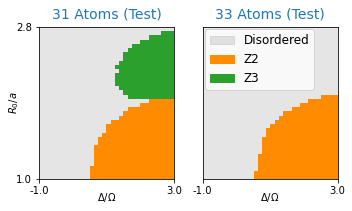

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(5.0,3.0))
row = 'Ours'
for j,nx in  enumerate([31,33]):
    test_df = dfs_CGM[nx]
    plot_df = process_df(test_df).copy()

    plot_df['phase'] = determine_phase_1D(plot_df['Z2'].values,plot_df['Z3'].values,z3_threshold=z3_threshold,
                                          z2_threshold=z2_threshold,)
    plot_df = plot_df.sort_values(['phase'])
    title = f"{nx} Atoms (Test)"
    title_config = dict(fontsize=14,color='tab:blue')
    legend_config=dict(loc='upper left', fontsize=12, bbox_to_anchor=(-.025, 1.025))
    if j == 0: kwargs = {"y_label":True,"y_ticks":True,"legend":False}
    else: kwargs = dict(y_label=False,y_ticks=False,legend=True)
    plot_phase_diagram(plot_df,title=title,given_ax=axes[j],hue_order=hue_order,
                       legend_config=legend_config, title_config=title_config,**kwargs)
fig.tight_layout()
fig.savefig(root+'figs/paper/1D-rydberg-size_test-ours.pdf')
fig.savefig(root+'figs/paper/1D-rydberg-size_test-ours.png',dpi=200)

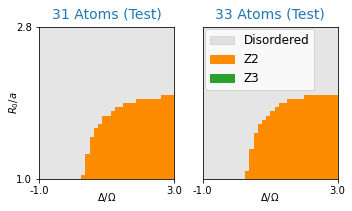

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(5.0,3.0))
row = 'Gaussian Kernel'
for j,nx in  enumerate([31,33]):
    test_df = dfs_rbf[nx]
    plot_df = process_df(test_df).copy()

    plot_df['phase'] = determine_phase_1D(plot_df['Z2'].values,plot_df['Z3'].values,z3_threshold=z3_threshold,
                                          z2_threshold=z2_threshold,)
    plot_df = plot_df.sort_values(['phase'])
    title = f"{nx} Atoms (Test)"
    title_config = dict(fontsize=14,color='tab:blue')
    legend_config=dict(loc='upper left', fontsize=12, bbox_to_anchor=(-.025, 1.025))
    if j == 0: kwargs = {"y_label":True,"y_ticks":True,"legend":False} 
    else: kwargs = dict(y_label=False,y_ticks=False,legend=True)
    plot_phase_diagram(plot_df,title=title,given_ax=axes[j],hue_order=hue_order,
                       legend_config=legend_config, title_config=title_config,**kwargs)
fig.tight_layout()
fig.savefig(root+'figs/paper/1D-rydberg-size_test-rbf.png',dpi=200)
fig.savefig(root+'figs/paper/1D-rydberg-size_test-rbf.pdf',)

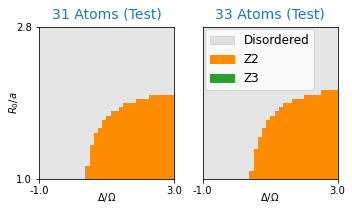

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(5.0,3.0))
row = 'NTK'
for j,nx in  enumerate([31,33]):
    test_df = dfs_ntk[nx]
    plot_df = process_df(test_df).copy()

    plot_df['phase'] = determine_phase_1D(plot_df['Z2'].values,plot_df['Z3'].values,z3_threshold=z3_threshold,
                                          z2_threshold=z2_threshold,)
    plot_df = plot_df.sort_values(['phase'])
    title = f"{nx} Atoms (Test)"
    title_config = dict(fontsize=14,color='tab:blue')
    legend_config=dict(loc='upper left', fontsize=12, bbox_to_anchor=(-.025, 1.025))
    if j == 0: kwargs = {"y_label":True,"y_ticks":True,"legend":False}
    else: kwargs = dict(y_label=False,y_ticks=False,legend=True)
    plot_phase_diagram(plot_df,title=title,given_ax=axes[j],hue_order=hue_order,
                       legend_config=legend_config, title_config=title_config,**kwargs)
fig.tight_layout()
fig.savefig(root+'figs/paper/1D-rydberg-size_test-ntk.pdf')
fig.savefig(root+'figs/paper/1D-rydberg-size_test-ntk.png',dpi=200)